---
title: Evaluating *AnyDorsal*
jupyter:
  kernelspec:
    display_name: Python (Pyseter)
    language: python
    name: pyseter_env
execute:
  cache: true
---

In this notebook, we'll demonstrate how do evaluate *AnyDorsal*'s' performance on a test dataset. We'll use the [Happy Whale and Dolphin Kaggle competition dataset](https://www.kaggle.com/competitions/happy-whale-and-dolphin/data) as an example. You can download the data by following that linked page (click the big "Download all" button). FYI, you'll have to create an account first.

In the [Predicting IDs](identify.qmd) notebook, we demonstrated how to extract features for the Happywhale dataset using a set of bounding boxes. Here, we'll load the features in.

In [ ]:
%config InlineBackend.figure_format = 'retina'

from pyseter.sort import load_features
from pyseter.identify import predict_ids
import matplotlib.pyplot as plt
import pandas as pd

data_dir = '/Users/PattonP/datasets/happywhale/'

feature_dir = data_dir + '/features'

reference_path = feature_dir + '/train_features.npy'
reference_files, reference_features = load_features(reference_path)

query_path = feature_dir + '/test_features.npy'
query_files, query_features = load_features(query_path)

In order to evaluate the performance of *AnyDorsal* on the test set, we'll need to know the IDs of animals in the train set and the test set. 

In [2]:
data_url = (
    'https://raw.githubusercontent.com/philpatton/pyseter/main/' 
    'data/happywhale-ids.csv'
)
id_df = pd.read_csv(data_url)

# excel on mac corrupts the IDs (no need to do this on PC or linux)
id_df['individual_id'] = id_df['individual_id'].apply(
    lambda x: str(int(float(x))) if 'E+' in str(x) else x
)

id_df.head(10)

,image,species,individual_id
0,000110707af0ba.jpg,gray_whale,fbe2b15b5481
1,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9
2,000562241d384d.jpg,humpback_whale,1a71fbb72250
3,0006287ec424cb.jpg,false_killer_whale,1424c7fec826
4,0007c33415ce37.jpg,false_killer_whale,60008f293a2b
5,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063
6,000809ecb2ccad.jpg,beluga,1ce3ba6a3c29
7,00087baf5cef7a.jpg,humpback_whale,8e5253662392
8,00098d1376dab2.jpg,humpback_whale,c4274d90be60
9,000a8f2d5c316a.jpg,bottlenose_dolphin,b9907151f66e


Now we'll predict the IDs in the query set. 

In [3]:
query_dict = dict(zip(query_files, query_features))
reference_dict = dict(zip(reference_files, reference_features))

prediction_df = predict_ids(reference_dict, query_dict, id_df, proposed_id_count=5)
prediction_df.head(20)

,image,rank,predicted_id,score
0,a704da09e32dc3.jpg,1,5f2296c18e26,0.500232
1,a704da09e32dc3.jpg,2,new_individual,0.500000
2,a704da09e32dc3.jpg,3,61f9e4cd30eb,0.432060
3,a704da09e32dc3.jpg,4,cb372e9b2c48,0.411830
4,a704da09e32dc3.jpg,5,43dad7ffa3c7,0.405389
5,de1569496d42f4.jpg,1,ed237f7c2165,0.826260
6,de1569496d42f4.jpg,2,new_individual,0.500000
7,de1569496d42f4.jpg,3,8c4a71fd3eb1,0.446297
8,de1569496d42f4.jpg,4,7d4deec3b721,0.424570
9,de1569496d42f4.jpg,5,fcc7ade0c50a,0.376510


## Mean average precision

We are going to evaluate *AnyDorsal* with Mean Average Precision (MAP). MAP evaluates a set of predictions, in this case, a set of 5 predictions. For a set of five ordered predictions, the precision score will be $1/1 = 1$ if the first prediction is correct, $1/2$ if the second is correct, and so on until $1/5$ if the fifth prediction is correct, or $0$ if none of the five predictions are correct. MAP is the mean precision score for a set.

So we need to get the `rank` of the correct ID for every image in the test set. One way to do so is to merge the ID DataFrame with the prediction DataFrame. We only want one row per test image, so we need to merge on both the image and ID columns. We can check to see that it worked by checking the number of rows in the result (there are `27956` images in the testing dataset).

In [4]:
# add the predictions and the scores to the id dataframe
performance_df = id_df.merge(
    prediction_df,
    how='left',
    left_on=['image', 'individual_id'],
    right_on=['image', 'predicted_id']
)

# filter out the training images
train_images = pd.read_csv(data_dir + '/train.csv').image
performance_df = performance_df.loc[~performance_df.image.isin(train_images)]
print(performance_df.shape)

(27956, 6)


In [9]:
performance_df.head(20)

,image,species,individual_id,rank,predicted_id,score,precision
0,000110707af0ba.jpg,gray_whale,fbe2b15b5481,1.0,fbe2b15b5481,0.871142,1.0
3,0006287ec424cb.jpg,false_killer_whale,1424c7fec826,1.0,1424c7fec826,0.794225,1.0
6,000809ecb2ccad.jpg,beluga,1ce3ba6a3c29,1.0,1ce3ba6a3c29,0.797251,1.0
8,00098d1376dab2.jpg,humpback_whale,c4274d90be60,1.0,c4274d90be60,0.816241,1.0
10,000b8d89c738bd.jpg,dusky_dolphin,new_individual,1.0,new_individual,0.500000,1.0
15,000e246888710c.jpg,melon_headed_whale,new_individual,2.0,new_individual,0.500000,0.5
16,000eb6e73a31a5.jpg,bottlenose_dolphin,77410a623426,1.0,77410a623426,0.709175,1.0
17,000fe6ebfc9893.jpg,spinner_dolphin,8805324885f2,1.0,8805324885f2,0.942707,1.0
20,0011f7a65044e4.jpg,spinner_dolphin,d5dcbb35777c,1.0,d5dcbb35777c,0.676094,1.0
21,0012ff300032e3.jpg,beluga,19b638e11443,1.0,19b638e11443,0.950292,1.0


Any image with an `NA` rank means that the true ID was not one of the `proposed_ids`. 

We can compute the precision by taking the reciprocal of the rank. After we do that, we'll fill the NA values with zero, since none of the five predictions were correct.

In [10]:
performance_df['precision'] = 1 / performance_df['rank'] 
performance_df['precision'] = performance_df['precision'].fillna(0)
map5 = performance_df.precision.mean()
print(f'MAP@5: {map5:0.3f}')

MAP@5: 0.863


For fun, we can look at the results by species

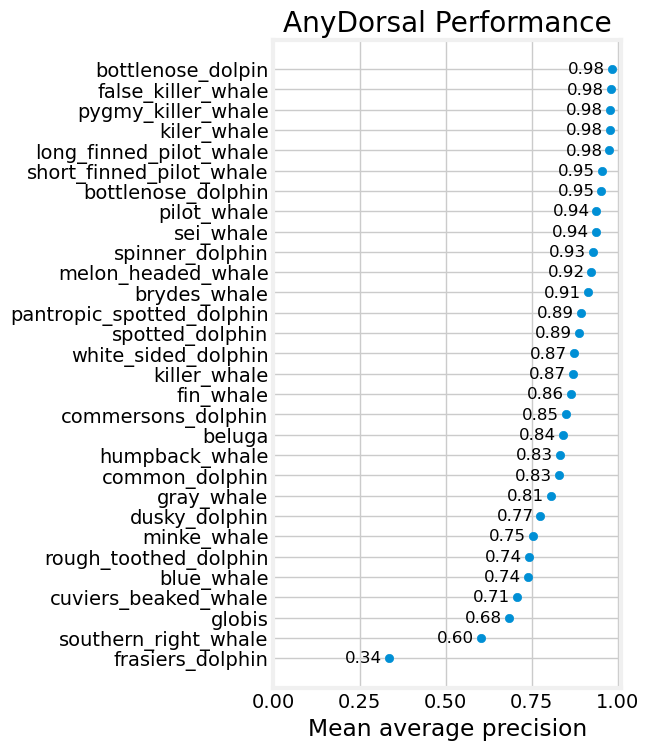

In [ ]:
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

map_df = (
    performance_df.groupby('species')
        .precision
        .mean()
        .rename('MAP')
        .reset_index()
        .sort_values('MAP')
)

fig, ax = plt.subplots(figsize=(4, 8))
ax.scatter(map_df.MAP, map_df.species)
for row in map_df.itertuples():
    ax.text(row.MAP - 0.02, row.species, f'{row.MAP:0.2f}', ha='right', 
            va='center', fontsize=12)
ax.set_xlim((0,1.01))
ax.set_title('AnyDorsal Performance')
ax.set_xlabel('Mean average precision')
plt.show()